## Attention Mechanism

### What Does the Attention Mechanism Solve?

Let's say that our goal is to develop a model that translates human language. We clearly can't translate word by word, since that grammatical structures of the languages at hand could be different.

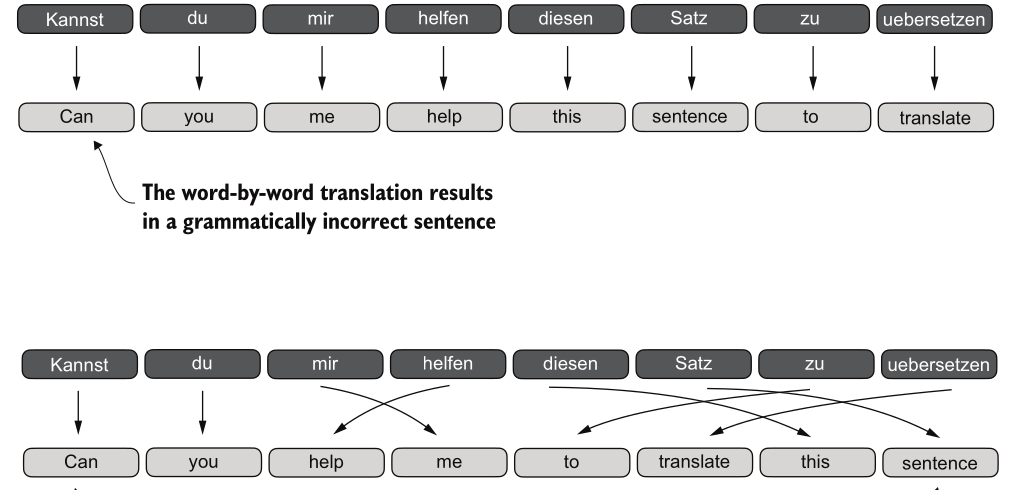

In order to solve this problem it is common to have a neural network with two components: an encoder and a decoder. The encoder transforms the text into a semantic-preserving form that does not depend on the original language while the decoder uses this form to produce the final translation. 

Before the transformer was a thing, RNN's were the standard neural network architecture that utilized an encoder and decoder. An RNN is a type of neural network that uses older outputs and feeds them to the current input. Specifically, for our text example we have than the encoder component will receive the text input sequentially, and in each step it will try to update its hidden state. The decoder then will receive this state and produce the translation one word at a time, while also updating the state.

The biggest drawback of this approach is that the hidden state is not capable to capture long-distance dependencies in the text.

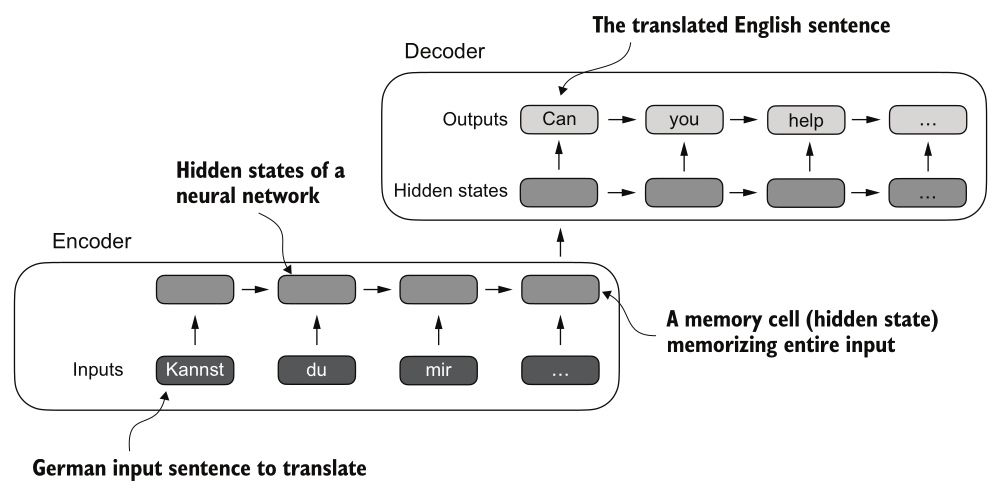

Because of this problem the self-attention mechanism was introduced.

## The Self-attention Mechanism

Self-attention is a mechanism that allows each position in the input sequence to consider all other positions in the same sequence when computing the inner state.

Remember that our input will be provided as a sequence of token embeddings. For each of these token embeddings our goal will be to compute **context vectors**: a context vector is just a version of our input token embedding but with context given by the other elements of the input sequence. 

The first thing we need in order to produce context vectors are weight matrices. These weight matrices will be optimized during training to produce our context vectors.

Our weight matrices 

$$ W_q,  W_k, W_v$$

will be utilized to project the embedded input tokens into **query**, **key**, and **value** vectors, as illustrated below:

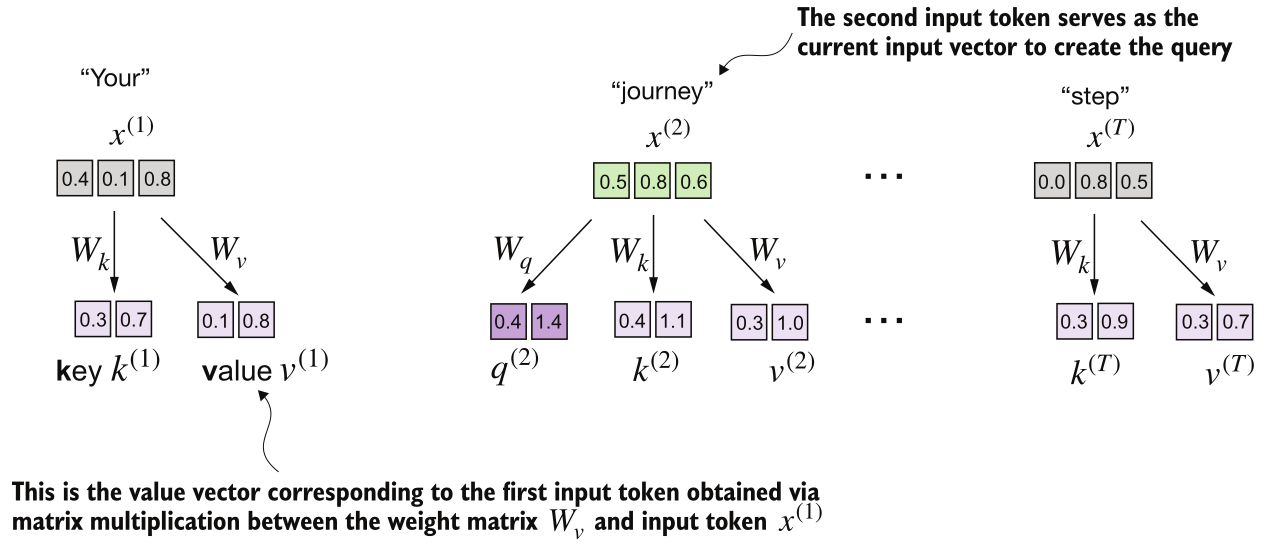

For an example, let's assume that we are computing the context vector of $x_1$, where $x_1$ is a token embedding of an input sequence $x_1, x_2, \ldots, x_n$. The first thing we need to do, is to take the product of the weight matrices $W_q, W_k, W_v$ with $x_1$ to obtain $x_q, x_k,x_v$. We then have to also obtain the key and value vectors for every other input in the sequence. $K = x_{1k}, \ldots, x_{nk}$, $V = x_{1v}, \ldots, x_{nv}$. We now have to obtain the attention scores as shown below:

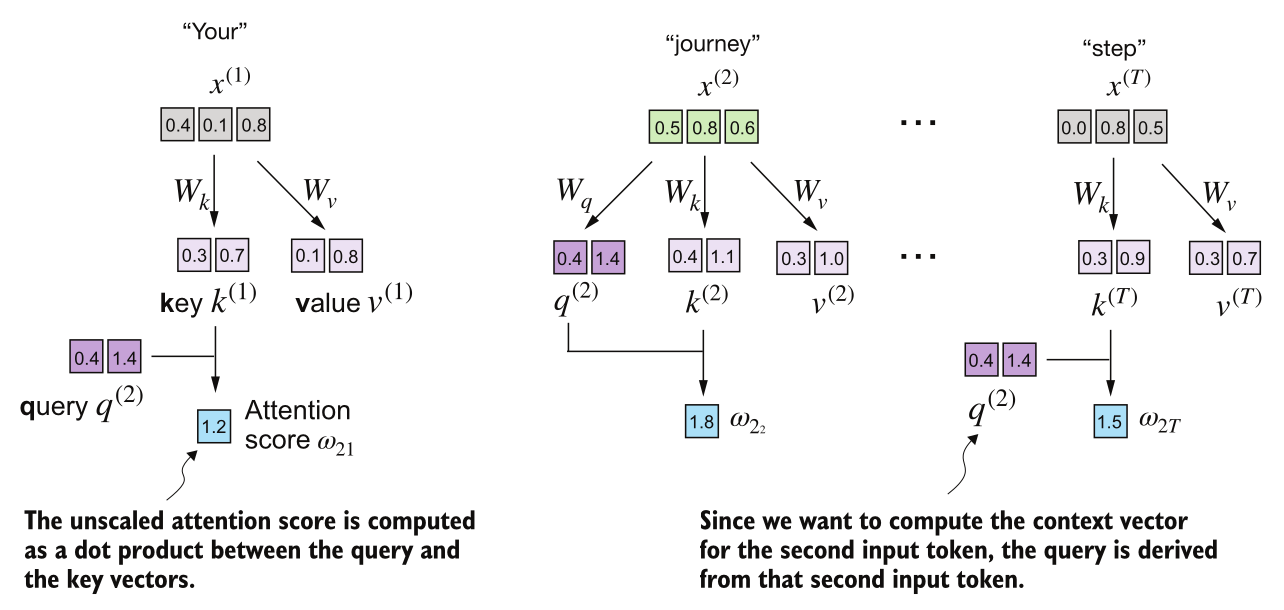

Basically, we compute the dot product between the query vector of $x_1$ and the key vector of all the other token embeddings. 

With the attention scores, we are now capable to obtain the attention weights as illustrated below;

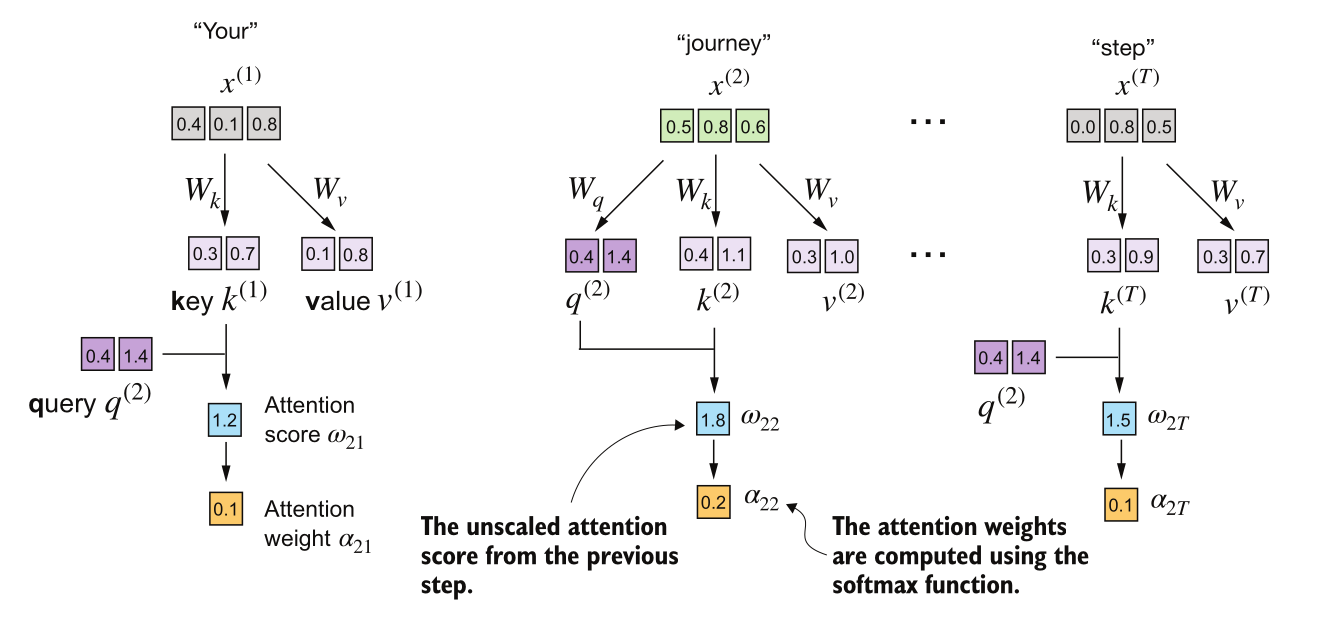

We obtain the attention weights by scaling the attention scores and using the softmax function. We scale the attention scores by dividing them by the square root of the embedding dimension of the keys. Notice that the reason we perform this is to improve the training performance by avoiding small gradients.

Finally, we obtain the final context vector by taking a linear combination of the value vectors with the attention weights.

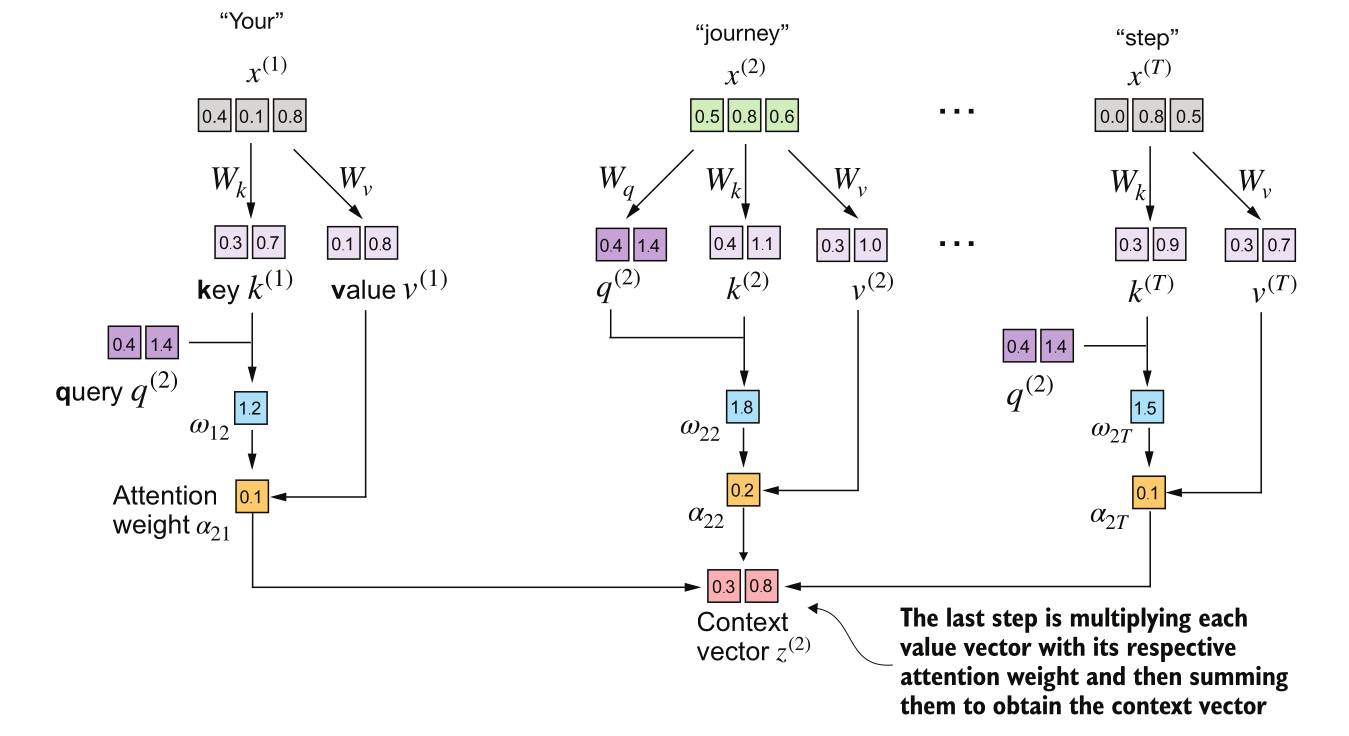

Let's now put everything together:

In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Linear(d_in,d_out, bias=False)
        self.W_key = nn.Linear(d_in, d_out, bias=False)
        self.W_val = nn.Linear(d_in, d_out, bias=False)

    def forward(self, x):
        keys = self.W_key(x)
        values = self.W_val(x)
        queries = self.W_query(x)

        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim = -1)
        context_vectors = attention_weights @ values
        return context_vectors    

## Causal Attention

For many LLM tasks, such as prediction of a word given a sequence of words, we want the self attention only to pay attention to the tokens that came before the current token being processed; causal attention does exactly that.

To obtain causal attention, for each token processed , we *mask out* the future tokens as illustrated below. Basically we mask out the attention weights above the diagonal and normalize.

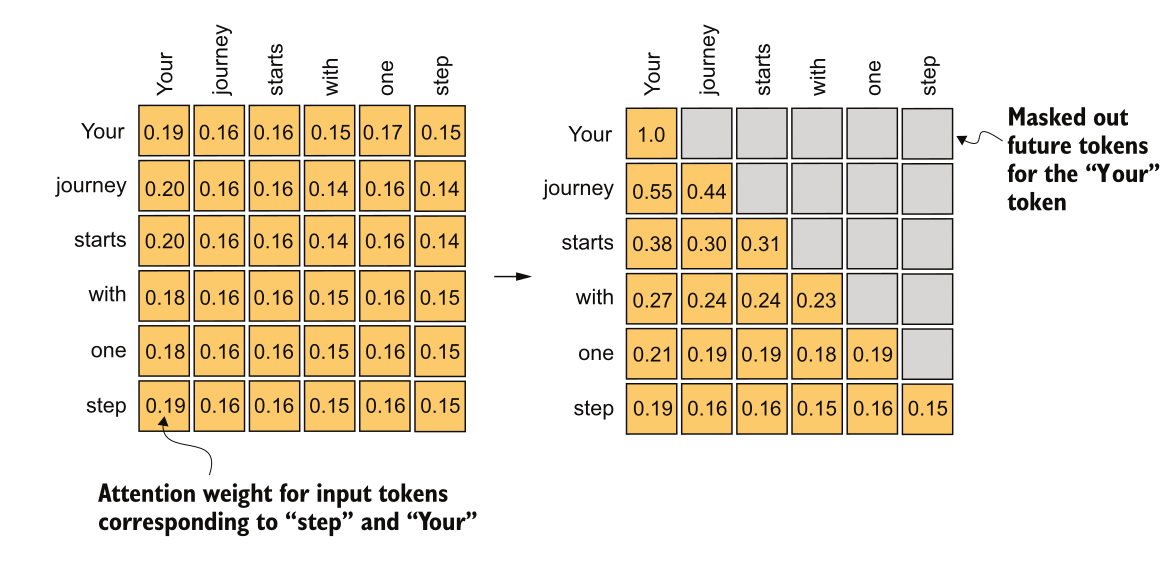

## Masking Additional Attention Weights With Dropout

**Dropout** consists of ignoring certain units of the layers of a neural network. This method helps with overfitting problems, by not allowing the model to rely too much on certain layers.

We will apply dropout after computing the attention weights.

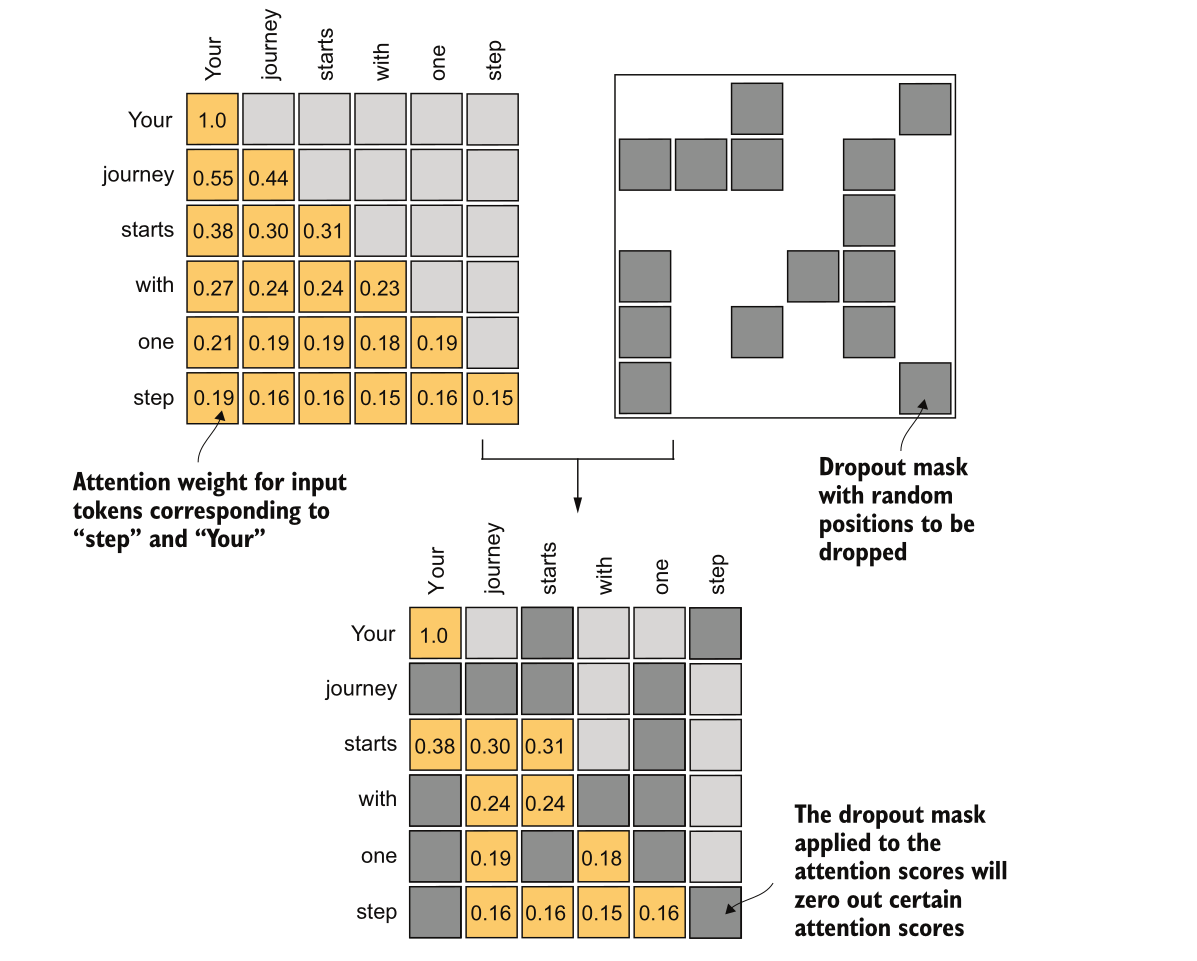

When dropout to an attention weight matrix is applied with a rate of $x\%$, we need to compensate by scaling the remaining values by $\frac{1}{x}$.

 Let's now add these additions into a class, plus we make additions to allow the class to accept batched inputs.

In [4]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout_rate):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in,d_out, bias=False)
        self.W_key = nn.Linear(d_in, d_out, bias=False)
        self.W_val = nn.Linear(d_in, d_out, bias=False)
        self.dropout = nn.Dropout(dropout_rate)

        self.register_buffer('mask', 
                             torch.triu(torch.ones(context_length, context_length), diagonal=1)
                            )

    def forward(self,x):
        batch_size, num_tokens, embedding_dim = x.shape        
        keys = self.W_key(x)
        values = self.W_val(x)
        queries = self.W_query(x)

        attn_scores = queries @ keys.transpose(1,2)  #t Swaps dimensions 1 and 2, keeping the batch dimension at the first position.

        # Apply Causal mask (-inf on future positions)
        # mask = self.mask[:num_tokens, :num_tokens]
        # attn_scores = attn_scores.masked_fill(mask, float("-inf"))

        # Memory efficient version
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec




## Extending single-head to multi-head attention


The term "multi-head" refers to dividing the attention mechanism into multiple "heads" each operating individually. In terms of our class above, we can consider an instance of our `CausalAttention` class as a "head".

In practice, Implementing multi-head attention simply involves creating multiple instances of the self-attention mechanism, each with their own weights, and then combining their outputs. 

Notice, that due to the quadratic complexity of the self-attention mechanism, using multiple heads is computationally expensive. Below is a figure that illustrates the structure of multi-head self-attention.

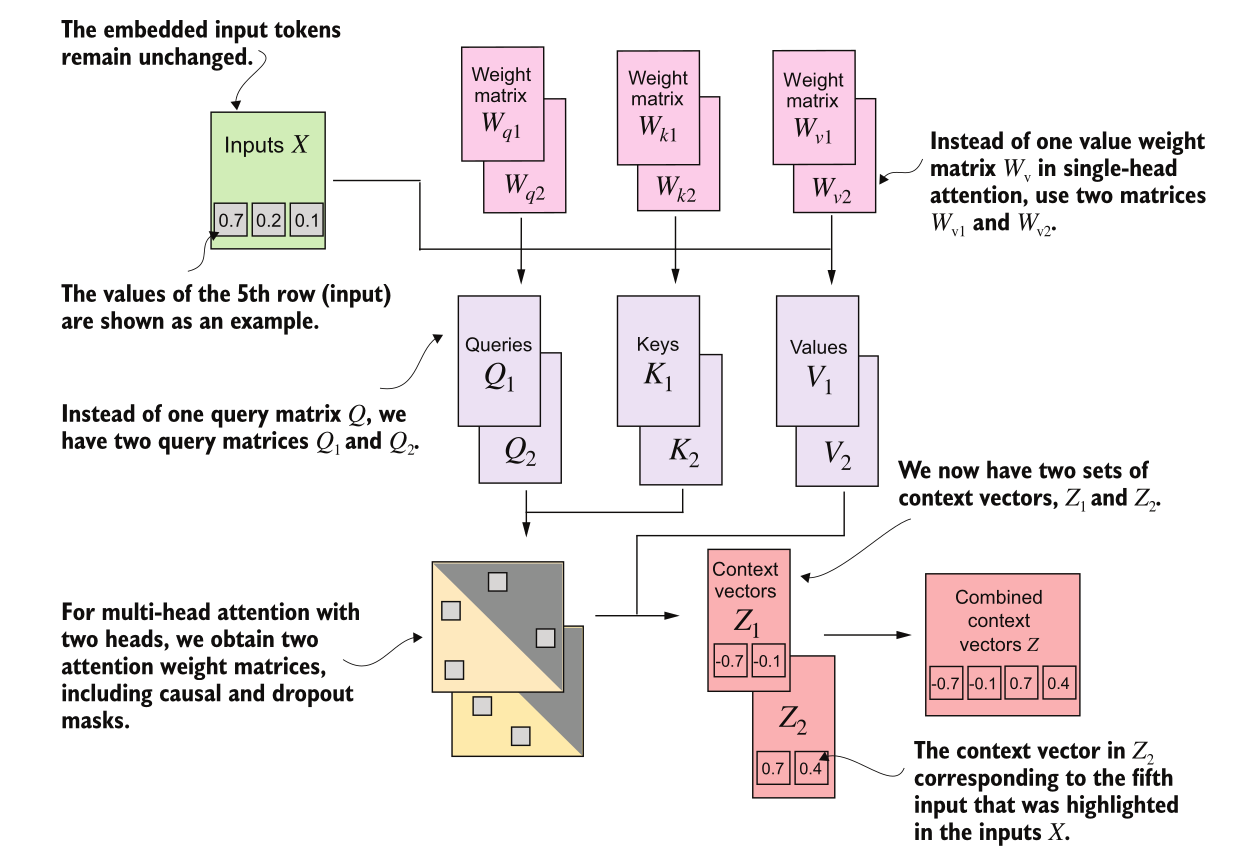

We can achieve this in code by simply defining a wrapper that stacks multiple `CausalAttention` classes.

In [5]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout_rate, num_heads):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in,d_out,context_length,dropout_rate) for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

The figure below illustrates how the wrapper works

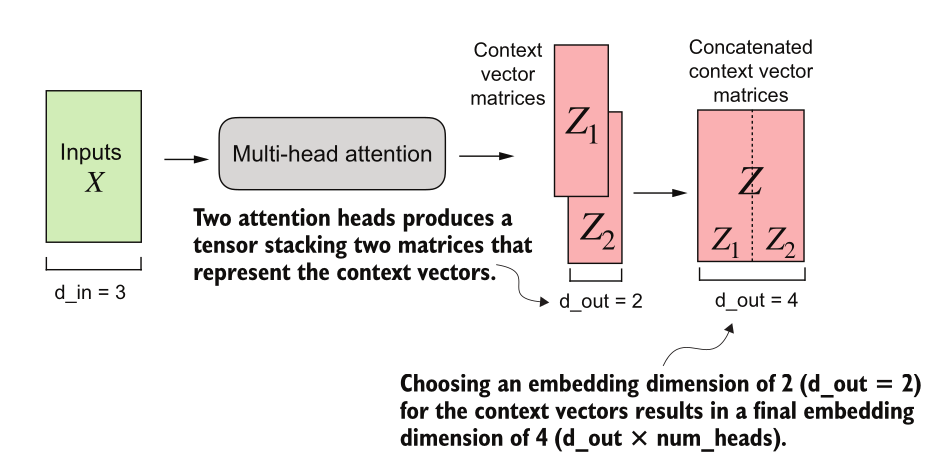

Notice that this class processes input sequentially, and we want to do this in parallel. Below is a final class with everything combined
(Code was given by Sebastian Raschka)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # As in `CausalAttention`, for inputs where `num_tokens` exceeds `context_length`, 
        # this will result in errors in the mask creation further below. 
        # In practice, this is not a problem since the LLM (chapters 4-7) ensures that inputs  
        # do not exceed `context_length` before reaching this forwar

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)